In [1]:
import os
from src.data_utils import MultiPurposeDataset, AugmentedList
from src.transformers_config import MODELS_dict
from src.consts import DOMAIN_TYPES, INTENT_TYPES, NAVA_TAGS
import fasttext
import nltk

/Users/meryemmhamdi/miniconda3/envs/zsl_nlu/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
class DataArgs:
    def __init__(self):
        self.data_root = "/Users/meryemmhamdi/USCGDrive/Fall23/SpacedRepetition/Datasets/"
        self.task_name = "tod"
        self.data_name = "mtop"
        self.data_format = "txt"
        self.setup_opt = "cll-er_kd"
        self.order_lst = "en_de_hi_th"
        self.languages = ["en", "de", "hi", "th"]
        self.order_class = 0
        self.order_lang = 0
        self.trans_model = "BertBaseMultilingualCased"
        self.use_slots = True
        self.seed = 42
        self.num_class_tasks = 10
        self.num_lang_tasks = 2
        self.multi_head_out = False
        self.max_mem_sz = 100
        self.er_strategy = "random"
        self.order_class = 0

        self.data_root = os.path.join(
            self.data_root,
            self.task_name.upper(),
            self.data_name.upper(),
        )

In [3]:
args = DataArgs()
print(args.task_name)
print(args.setup_opt)

tod
cll-er_kd


In [4]:

tokenizer = MODELS_dict[args.trans_model][1].from_pretrained(
    MODELS_dict[args.trans_model][0], do_lower_case=True, do_basic_tokenize=False
)

dataset = MultiPurposeDataset(args, tokenizer)

----------lang: en
Reading train split ... 
Reading dev split ... 
Reading test split ... 
----------lang: de
Reading train split ... 
Reading dev split ... 
Reading test split ... 
----------lang: hi
Reading train split ... 
Reading dev split ... 
Reading test split ... 
----------lang: th
Reading train split ... 
Reading dev split ... 
Reading test split ... 
********* CLL-ER-KD
ordered_langs: ['en', 'de', 'hi', 'th']


### 1. For every language and intent, take all examples and strip out stop words and calculate the most three appearing words for that intent and do that for all intents. (do it for each domain look for most frequent words and for each intent look for most frequent words that is not within the most frequent words for intents.)

In [5]:
from wordcloud import STOPWORDS
from string import punctuation

NOISY_WORDS = list(STOPWORDS) + list(punctuation)

def custom_tokenizer(sentences):
    """ 
        - Uses fasttext tokenizer
        - Convert to lowercase
        - Filter stopwords
        - Filter punctuation    
    """
    return [
        list(filter(lambda word: word not in NOISY_WORDS, fasttext.tokenize(sentence.lower())))
        for sentence in sentences
    ]


In [6]:
from nltk.stem import WordNetLemmatizer

lemmatizer = WordNetLemmatizer()

def extract_only_nava_words(sentences):
    """
        Expected sentences from a given domain or intent
    """
    navas = []

    for sentence in sentences:
        for word,pos in nltk.pos_tag(nltk.word_tokenize(sentence)):
            if (pos in NAVA_TAGS ):
                navas.append(lemmatizer.lemmatize(word.lower()))
    return navas

def extract_only_nava_words_per_sentence(sentence):
    """
        Expected one sentence
    """
    navas = []
    for word,pos in nltk.pos_tag(nltk.word_tokenize(sentence)):
        if (pos in NAVA_TAGS ):
            navas.append(lemmatizer.lemmatize(word.lower()))
    return navas

In [7]:
sentences = ["I'm giving it a try!!!"]
print(custom_tokenizer(sentences))
print(extract_only_nava_words(sentences))


[['giving', 'try!!!']]
['giving', 'try']


#### a. Look for most frequent words within a domain for each language

In [8]:
class_types = dataset.class_types
LANG = "en"

sentences_domains = {domain.lower(): [] for domain in DOMAIN_TYPES[args.data_name]}
sentences_intents = {intent: [] for intent in INTENT_TYPES[args.data_name]}

for eg in dataset.train_set[LANG]:
    domain, sub_intent = class_types[eg.label].split(":")
    sentences_domains[domain].append(eg.text)
    sentences_intents[class_types[eg.label]].append(eg.text)


In [9]:
print("Frequency per domain:", {domain: len(sentences_domains[domain]) for domain in sentences_domains})
print("Frequency per intent:", {intent: len(sentences_intents[intent]) for intent in sentences_intents})

Frequency per domain: {'alarm': 1402, 'calling': 2187, 'event': 929, 'messaging': 1165, 'music': 1353, 'news': 1219, 'people': 1231, 'recipes': 1303, 'reminder': 2157, 'timer': 1064, 'weather': 1657}
Frequency per intent: {'alarm:CREATE_ALARM': 1045, 'alarm:DELETE_ALARM': 59, 'alarm:GET_ALARM': 101, 'alarm:SILENCE_ALARM': 64, 'alarm:SNOOZE_ALARM': 84, 'alarm:UPDATE_ALARM': 49, 'calling:ANSWER_CALL': 45, 'calling:CANCEL_CALL': 1, 'calling:CREATE_CALL': 1177, 'calling:END_CALL': 121, 'calling:GET_AVAILABILITY': 214, 'calling:GET_CALL': 54, 'calling:GET_CALL_CONTACT': 16, 'calling:GET_CALL_TIME': 37, 'calling:HOLD_CALL': 10, 'calling:IGNORE_CALL': 53, 'calling:MERGE_CALL': 1, 'calling:RESUME_CALL': 4, 'calling:SET_AVAILABLE': 52, 'calling:SET_DEFAULT_PROVIDER_CALLING': 8, 'calling:SET_UNAVAILABLE': 83, 'calling:SWITCH_CALL': 49, 'calling:UPDATE_CALL': 218, 'calling:UPDATE_METHOD_CALL': 44, 'event:DISPREFER': 2, 'event:GET_ATTENDEE_EVENT': 18, 'event:GET_CATEGORY_EVENT': 16, 'event:GET_DAT

In [10]:
import collections
most_frequent_words_domains = {domain: [] for domain in sentences_domains}
for domain in sentences_domains:
    domain_words = extract_only_nava_words(sentences_domains[domain])
    for word, count in collections.Counter(domain_words).most_common(10):
        most_frequent_words_domains[domain].append(word)

In [11]:
for domain in most_frequent_words_domains:
    print("domain:", domain, " most_frequent_words[domain]:", most_frequent_words_domains[domain])

domain: alarm  most_frequent_words[domain]: ['alarm', 'set', 'pm', 'minute', 'please', 'tomorrow', 'create', 'make', 'snooze', 'morning']
domain: calling  most_frequent_words[domain]: ['call', 'please', 'whatsapp', 'video', 'now', 'online', 'add', 's', 'available', 'start']
domain: event  most_frequent_words[domain]: ['event', 'do', 'weekend', 'going', 'happening', 'tonight', 'thing', 'next', 'week', 'concert']
domain: messaging  most_frequent_words[domain]: ['message', 'video', 'send', 'text', 'ask', 'please', 'let', 'i', 'tell', 'be']
domain: music  most_frequent_words[domain]: ['play', 'song', 'music', 'please', 'album', 'playlist', 'iheartradio', 'listen', 'spotify', 'track']
domain: news  most_frequent_words[domain]: ['news', 'headline', 'today', 'read', 'latest', 'give', 'recent', 'update', 'please', 'story']
domain: people  most_frequent_words[domain]: ['friend', 'did', 'work', 'tell', 'birthday', 'live', 'show', 'address', 'anyone', 'doe']
domain: recipes  most_frequent_words[d

##### b. Look for most frequent words within an intent that are not the most frequent within its corresponding intent:

In [12]:
most_frequent_words_intents = {intent: [] for intent in sentences_intents}
for intent in sentences_intents:
    intent_words = extract_only_nava_words(sentences_intents[intent])
    domain = intent.split(":")[0]
    filtered_intent_words = list(filter(lambda word: word not in most_frequent_words_domains[domain], intent_words))
    print(" intent_words:", len(intent_words), " filtered_intent_words:", len(filtered_intent_words))
    for word, count in collections.Counter(filtered_intent_words).most_common(10):
        most_frequent_words_intents[intent].append(word)

 intent_words: 3898  filtered_intent_words: 1507
 intent_words: 184  filtered_intent_words: 104
 intent_words: 310  filtered_intent_words: 194
 intent_words: 144  filtered_intent_words: 79
 intent_words: 255  filtered_intent_words: 66
 intent_words: 171  filtered_intent_words: 104
 intent_words: 163  filtered_intent_words: 104
 intent_words: 2  filtered_intent_words: 1
 intent_words: 4536  filtered_intent_words: 2937
 intent_words: 345  filtered_intent_words: 229
 intent_words: 601  filtered_intent_words: 371
 intent_words: 212  filtered_intent_words: 158
 intent_words: 50  filtered_intent_words: 43
 intent_words: 167  filtered_intent_words: 132
 intent_words: 31  filtered_intent_words: 22
 intent_words: 170  filtered_intent_words: 128
 intent_words: 3  filtered_intent_words: 2
 intent_words: 15  filtered_intent_words: 11
 intent_words: 141  filtered_intent_words: 96
 intent_words: 31  filtered_intent_words: 26
 intent_words: 244  filtered_intent_words: 215
 intent_words: 217  filtered

In [13]:
for intent in most_frequent_words_intents:
    print("intent:", intent, " most_frequent_words[intent]:", most_frequent_words_intents[intent])

intent: alarm:CREATE_ALARM  most_frequent_words[intent]: ['friday', 'new', 'tuesday', 'monday', 'hour', 'wake', 'go', 'thursday', 'now', 'sunday']
intent: alarm:DELETE_ALARM  most_frequent_words[intent]: ['cancel', 'delete', 'get', 'rid', 'remove', 'deleted', 'next', 'clear', 'be', 'month']
intent: alarm:GET_ALARM  most_frequent_words[intent]: ['time', 'show', 'much', 'next', 'left', 'see', 'tell', 'long', 'have', 'current']
intent: alarm:SILENCE_ALARM  most_frequent_words[intent]: ['turn', 'shut', 'stop', 'now', 'quiet', 'reset', 'ringing', 'dismiss', 'enough', 'mute']
intent: alarm:SNOOZE_ALARM  most_frequent_words[intent]: ['hour', 'more', 'min', 'next', 'pause', 'sleep', 'put', 'let', 'wake', 'give']
intent: alarm:UPDATE_ALARM  most_frequent_words[intent]: ['change', 'update', 'modify', 'repeat', 'next', 'wake', 'friday', 'edit', 'get', 'move']
intent: calling:ANSWER_CALL  most_frequent_words[intent]: ['answer', 'pick', 'new', 'accept', 'incoming', 'take', 'brother', 'mom', 'law', 

#### c. Define a simple lexicon-based classifier to check the degree of easiness:

In [14]:
train_pred_intents = []
train_true_intents = []
for i, eg in enumerate(dataset.train_set[LANG]):
    # Tokenize and extract only NAVAs
    sentence_navas = extract_only_nava_words_per_sentence(eg.text)
    scores = {intent: 0 for intent in most_frequent_words_intents}
    for nava_word in sentence_navas:
        # Go over lexicon for each intent and get their score 
        for intent in most_frequent_words_intents:
            for words in most_frequent_words_intents[intent]:
                if nava_word in words:
                    scores[intent] += 1

    keywords = most_frequent_words_intents["reminder:CREATE_REMINDER"]
    sortedDict = sorted(scores.items(), reverse=True, key=lambda x:x[1])
    pred_intent = next(iter(sortedDict))[0]
    true_intent = class_types[eg.label]
    train_pred_intents.append(pred_intent)
    train_true_intents.append(true_intent)
    print("sentence_navas:", sentence_navas, pred_intent, " True label >>>", true_intent)

sentence_navas: ['remind', 'check', 'oven', 'minute'] music:FAST_FORWARD_MUSIC  True label >>> reminder:CREATE_REMINDER
sentence_navas: ['which', 'friend', 'graduated', 'mdc'] people:GET_CONTACT  True label >>> people:GET_CONTACT
sentence_navas: ['need', 'winter', 'coat', 'november', 'new', 'york'] alarm:CREATE_ALARM  True label >>> weather:GET_WEATHER
sentence_navas: ['genre', 'music', 'song'] event:GET_EVENT  True label >>> music:GET_TRACK_INFO_MUSIC
sentence_navas: ['play', 'ed', 'sheeran', 'song'] music:PREVIOUS_TRACK_MUSIC  True label >>> music:PLAY_MUSIC
sentence_navas: ['find', 'leena', 'also', 'coming', 'weekend', 'movie'] people:GET_CONTACT  True label >>> messaging:SEND_MESSAGE
sentence_navas: ['long', 'grill', 'cat', 'fish'] alarm:GET_ALARM  True label >>> recipes:GET_INFO_RECIPES
sentence_navas: ['play', 'top', 'pop', 'hit'] music:PLAY_MUSIC  True label >>> music:PLAY_MUSIC
sentence_navas: ['call', 'talia', 's', 'auntie'] event:SET_RSVP_YES  True label >>> calling:CREATE_CA

In [15]:
test_pred_intents = []
test_true_intents = []
for i, eg in enumerate(dataset.test_set[LANG]):
    # Tokenize and extract only NAVAs
    sentence_navas = extract_only_nava_words_per_sentence(eg.text)
    scores = {intent: 0 for intent in most_frequent_words_intents}
    for nava_word in sentence_navas:
        # Go over lexicon for each intent and get their score 
        for intent in most_frequent_words_intents:
            for words in most_frequent_words_intents[intent]:
                if nava_word in words:
                    scores[intent] += 1

    keywords = most_frequent_words_intents["reminder:CREATE_REMINDER"]
    sortedDict = sorted(scores.items(), reverse=True, key=lambda x:x[1])
    pred_intent = next(iter(sortedDict))[0]
    true_intent = class_types[eg.label]
    test_pred_intents.append(pred_intent)
    test_true_intents.append(true_intent)
    print("sentence_navas:", sentence_navas, pred_intent, " True label >>>", true_intent)

sentence_navas: ['set', 'alarm', 'pm', 'pm', 'pm'] timer:CREATE_TIMER  True label >>> alarm:CREATE_ALARM
sentence_navas: ['message', 'matt', 'ask', 'flight', 'departing'] messaging:GET_MESSAGE  True label >>> messaging:SEND_MESSAGE
sentence_navas: ['remove', 'reminder', 'michelle', 'birthday', 'party', 'next', 'week'] alarm:DELETE_ALARM  True label >>> reminder:DELETE_REMINDER
sentence_navas: ['got', 'set'] weather:GET_SUNSET  True label >>> alarm:GET_ALARM
sentence_navas: ['start', 'snowing'] event:GET_DATE_TIME_EVENT  True label >>> weather:GET_WEATHER
sentence_navas: ['recipe', 'be', 'cooked', 'crockpot'] alarm:DELETE_ALARM  True label >>> recipes:GET_RECIPES
sentence_navas: ['make', 'stir', 'fried', 'loofah'] calling:CREATE_CALL  True label >>> recipes:GET_RECIPES
sentence_navas: ['please', 'send', 'text', 'jose', 'bill'] messaging:CANCEL_MESSAGE  True label >>> messaging:SEND_MESSAGE
sentence_navas: ['set', 'alarm', 'tomorrow'] weather:GET_SUNSET  True label >>> alarm:CREATE_ALARM

In [16]:
acc = 0
for true_intent, pred_intent in zip(train_true_intents, train_pred_intents):
    if true_intent == pred_intent:
        acc += 1
acc = acc/len(train_true_intents)
print("Train accuracy:", acc)

acc = 0
for true_intent, pred_intent in zip(test_true_intents, test_pred_intents):
    if true_intent == pred_intent:
        acc += 1
acc = acc/len(train_true_intents)
print("Test accuracy:", acc)

Train accuracy: 0.154656283908853
Test accuracy: 0.03733963107167933


In [18]:
import pickle
with open("most_frequent_words_intents.pickle", "wb") as file:
    pickle.dump(most_frequent_words_intents, file)


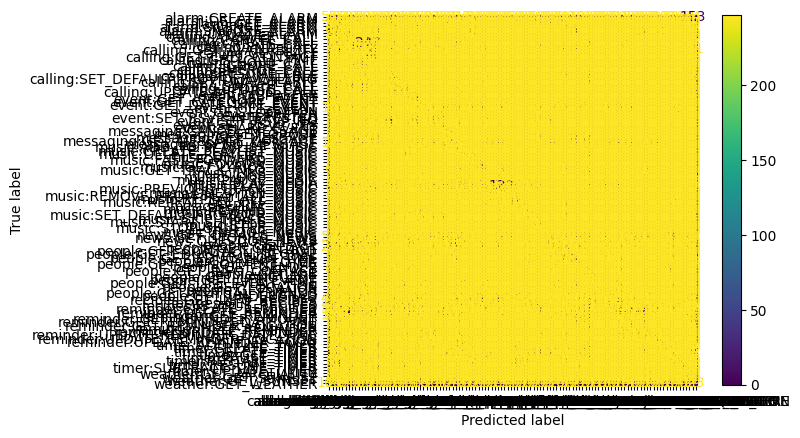

In [17]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
classes_ = list(most_frequent_words_intents.keys())
cm = confusion_matrix(test_true_intents, test_pred_intents, labels=classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=classes_)
disp.plot()
plt.show()